In [1]:
import time
from auto_robot_design.pinokla.closed_loop_kinematics import closedLoopProximalMount

from auto_robot_design.pinokla.calc_criterion import search_workspace
from pinocchio.visualize import MeshcatVisualizer
import meshcat
import numpy as np
from itertools import product
import matplotlib.pyplot as plt

import pinocchio as pin
from auto_robot_design.pinokla.closed_loop_kinematics import ForwardK
from auto_robot_design.pinokla.closed_loop_jacobian import jacobian_constraint

from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot
from auto_robot_design.generator.restricted_generator.two_link_generator import TwoLinkGenerator

In [2]:
def angle_wrap(arr):
    # return (arr + np.pi) % (2 * np.pi) - np.pi
    return ((-arr + np.pi) % (2 * np.pi) - np.pi) * -1

In [43]:
gen = TwoLinkGenerator()
builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE)
graphs_and_cons = gen.get_standard_set()
np.set_printoptions(precision=3, linewidth=300, suppress=True, threshold=10000)

graph_jp, __ = graphs_and_cons[0]
robo, robo_free = jps_graph2pinocchio_robot(graph_jp, builder)

q0 = closedLoopProximalMount(
    robo.model,
    robo.data,
    robo.constraint_models,
    robo.constraint_data,
    max_it=100,
)

In [45]:
viz = MeshcatVisualizer(robo.model, robo.visual_model, robo.visual_model)
# viz.viewer = meshcat.Visualizer().open()
# viz.clean()
# viz.loadViewerModel()
viz.initViewer(loadModel=True)
viz.display(q0)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [5]:
def jacobian_constraint_custom(model,data,constraint_model,constraint_data,actuation_model,q0):
    #update of the jacobian an constraint model
    # pin.computeJointJacobians(model,data,q0)
    cdatas = pin.StdVec_RigidConstraintData()
    cmodels = pin.StdVec_RigidConstraintModel()
    for cm,cd in zip(constraint_model,constraint_data):
        cdatas.append(cd)
        cmodels.append(cm)
    Jright = pin.getConstraintsJacobian(model,data,cmodels,cdatas)
    

    LJ=[np.array(())]*len(constraint_model)
    for (cm,cd,i) in zip(constraint_model,constraint_data,range(len(LJ))):
        LJ[i]=pin.getConstraintJacobian(model,data,cm,cd)
        

    #init of constant
    Lidmot=actuation_model.idvmot
    Lidfree=actuation_model.idvfree
    nv=model.nv
    nv_mot=len(Lidmot)
    nv_free=len(Lidfree)
    Lnc=[J.shape[0] for J in LJ]
    nc=int(np.sum(Lnc))
    
    
    Jmot=np.zeros((nc,nv_mot))
    Jfree=np.zeros((nc,nv_free))
    
    #separation between Jmot and Jfree
    nprec=0
    for J,n in zip(LJ,Lnc):
        Smot=np.zeros((nv,nv_mot))
        Smot[Lidmot,range(nv_mot)]=1
        Sfree=np.zeros((nv,nv_free))
        Sfree[Lidfree,range(nv_free)]=1

        Jmot[nprec:nprec+n,:]=J@Smot
        Jfree[nprec:nprec+n,:]=J@Sfree

        nprec=nprec+n
    
    #act2pass?
    # E_tau = np.zeros((nv, nv))
    # E_tau[range(nv_mot), Lidmot] = 1
    # E_tau[range(nv_mot,nv), Lidfree] = 1
    # # computation of dq/dqmot
    # pinvJfree=np.linalg.pinv(Jfree)
    # dq_dmot_no=np.concatenate((np.identity(nv_mot),-pinvJfree@Jmot))
    # #re order dq/dqmot
    # dq_dmot=dq_dmot_no.copy()
    # dq_dmot[Lidmot]=dq_dmot_no[:nv_mot,:]
    # dq_dmot[Lidfree]=dq_dmot_no[nv_mot:,:]
    # return dq_dmot_no, E_tau
    
    return (Jmot, Jfree), Jright

In [6]:
def jacobian_closed(model,data,constraint_model,constraint_data,actuation_model,q0, ideff):
    Jmot, Jfree = jacobian_constraint(model,data,constraint_model,constraint_data,actuation_model,q0) # q0 does nothing here

    #init of constant
    Lidmot=actuation_model.idvmot
    Lidfree=actuation_model.idvfree
    nv_mot=len(Lidmot)

    # computation of dq/dqmot
    pinvJfree=np.linalg.pinv(Jfree)
    dq_dmot_no=np.concatenate((np.identity(nv_mot),-pinvJfree@Jmot)) 
    # DOES NOT CHANGE DURING SIM
    
    #re order dq/dqmot
    dq_dmot=dq_dmot_no.copy()
    dq_dmot[Lidmot]=dq_dmot_no[:nv_mot,:]
    dq_dmot[Lidfree]=dq_dmot_no[nv_mot:,:]
    
    #computation of the closed-loop jacobian
    # Jf_closed = pin.computeFrameJacobian(model,data,q0,ideff,pin.LOCAL)@dq_dmot
    Jf_closed = pin.computeFrameJacobian(model,data,q0,ideff,pin.LOCAL_WORLD_ALIGNED)@dq_dmot
    return Jf_closed

In [7]:
def calc_dqdmot(Jmot, Jfree, actuation_model):
    #init of constant
    Lidmot=actuation_model.idvmot
    Lidfree=actuation_model.idvfree
    nv_mot=len(Lidmot)

    # computation of dq/dqmot
    pinvJfree=np.linalg.pinv(Jfree)
    dq_dmot_no=np.concatenate((np.identity(nv_mot),-pinvJfree@Jmot)) 
    
    #re order dq/dqmot
    dq_dmot=dq_dmot_no.copy()
    dq_dmot[Lidmot]=dq_dmot_no[:nv_mot,:]
    dq_dmot[Lidfree]=dq_dmot_no[nv_mot:,:]
    return dq_dmot

In [8]:
def Jcl_toXZ_svds(Jclosed):
    Jclosed = Jclosed[(0,2),:]
    Jinv = np.linalg.pinv(Jclosed)
    U, S, Vh = np.linalg.svd(Jclosed, full_matrices=False)
    U2, S2, Vh2 = np.linalg.svd(Jinv, full_matrices=False)

    # Jinv = np.linalg.pinv(Jclosed)
    # U, S, Vh = np.linalg.svd(Jclosed, full_matrices=False)
    # U2, S2, Vh2 = np.linalg.svd(Jinv, full_matrices=False)
    # # print('cut',Jclosed[(0,2),:])
    # # print('svd',np.dot(U[(0,2),:]*S, Vh))
    # # print('invsvdf', np.dot(U2*S2, Vh2)[:,(0,2)])
    # U = U[(0,2),:]
    # Vh2 = Vh2[:,(0,2)]
    # # print('svdcut',np.dot(U*S, Vh))

    # Jclosed = Jclosed[(0,2),:]
    # # print('invcut',Jinv[:,(0,2)])
    # Jinv = np.linalg.pinv(Jclosed) 
    # # print('invfromcut',Jinv) #differs from 3 other variants
    # # print('invsvd', np.dot(U2*S2, Vh2))
    
    # U, S, Vh = np.linalg.svd(Jclosed, full_matrices=False)
    # U2, S2, Vh2 = np.linalg.svd(Jinv, full_matrices=False)
    return (U,S,Vh), (U2,S2,Vh2), Jclosed, Jinv

In [9]:
from auto_robot_design.pinokla.robot_utils import freezeJoints, freezeJointsWithoutVis

def ForwardKCustom(
    model,
    constraint_model,
    actuation_model,
    q_prec=None,
    max_it=100,
    alpha = 0.7,
    eps=1e-12,
    rho=1e-10,
    mu=1e-4,
    connectivity=1e-12
):
    """
    q=proximalSolver(model,data,constraint_model,constraint_data,max_it=100,eps=1e-12,rho=1e-10,mu=1e-4)

    Build the robot in respect to the constraints using a proximal solver.

    Args:
        model (pinocchio.Model): Pinocchio model.
        data (pinocchio.Data): Pinocchio data.
        constraint_model (list): List of constraint models.
        constraint_data (list): List of constraint data.
        actuation_model (ActuationModelFreeFlyer): Actuation model.
        q_prec (list or np.array, optional): Initial guess for joint positions. Defaults to [].
        max_it (int, optional): Maximum number of iterations. Defaults to 100.
        eps (float, optional): Convergence threshold for primal and dual feasibility. Defaults to 1e-12.
        rho (float, optional): Scaling factor for the identity matrix. Defaults to 1e-10.
        mu (float, optional): Penalty parameter. Defaults to 1e-4.

    Returns:
        np.array: Joint positions of the robot respecting the constraints.

    raw here (L84-126):https://gitlab.inria.fr/jucarpen/pinocchio/-/blob/pinocchio-3x/examples/simulation-closed-kinematic-chains.py
    """

    Lid = actuation_model.idMotJoints
    Lid_q = actuation_model.idqmot

    q_previous = np.delete(q_prec.copy(), Lid_q, axis=0)

    (reduced_model, reduced_constraint_models, reduced_actuation_model) = freezeJointsWithoutVis(
        model, constraint_model, None, Lid, q_prec
    )

    reduced_data = reduced_model.createData()
    reduced_constraint_data = [c.createData() for c in reduced_constraint_models]

    q = np.delete(q_prec, Lid_q, axis=0)
    constraint_dim = 0
    for cm in reduced_constraint_models:
        constraint_dim += cm.size()

    y = np.ones((constraint_dim))
    reduced_data.M = np.eye(reduced_model.nv) * rho
    kkt_constraint = pin.ContactCholeskyDecomposition(
        reduced_model, reduced_constraint_models
    )

    for k in range(max_it):
        pin.computeJointJacobians(reduced_model, reduced_data, q)
        kkt_constraint.compute(
            reduced_model,
            reduced_data,
            reduced_constraint_models,
            reduced_constraint_data,
            mu,
        )

        constraint_value = np.concatenate(
            [
                (pin.log(cd.c1Mc2).np[: cm.size()])
                for (cd, cm) in zip(reduced_constraint_data, reduced_constraint_models)
            ]
        )

        # LJ = []
        # for cm, cd in zip(reduced_constraint_models, reduced_constraint_data):
        #     Jc = pin.getConstraintJacobian(reduced_model, reduced_data, cm, cd)
        #     LJ.append(Jc)
        # J = np.concatenate(LJ)

        primal_feas = np.linalg.norm(constraint_value, np.inf)
        # print(f'pf={primal_feas}, qL2={np.linalg.norm(q-q_previous)}')
        # dual_feas = np.linalg.norm(J.T.dot(constraint_value + y), np.inf)
        if primal_feas < eps:
            # print("Convergence achieved")
            break
        # print("constraint_value:", np.linalg.norm(constraint_value))
        rhs = np.concatenate([-constraint_value - y * mu, np.zeros(reduced_model.nv)])

        dz = kkt_constraint.solve(rhs)
        dy = dz[:constraint_dim]
        dq = dz[constraint_dim:]


        q = pin.integrate(reduced_model, q, -alpha * dq)
        y -= alpha * (-dy + y)

    # print('mod',constraint_model)
    # # print('dim',constraint_dim)
    # print('redmod',reduced_constraint_models)
    # print('reddata',reduced_constraint_data)
    # print('val',constraint_value)
    q_final = q_prec
    free_q_dict = zip(actuation_model.idqfree, q)
    for index, value in free_q_dict:
        q_final[index] = value
    return q_final, primal_feas

In [23]:
def search_workspace_FK(
    model,
    data,
    effector_frame_name: str,
    base_frame_name: str,
    q_space: np.ndarray,
    actuation_model,
    constraint_models,
    constraint_data,
    viz=None, link_names=None, q_default=None
):
    """Iterate forward kinematics over q_space and try to minimize constrain value.

    Args:
        model (_type_): _description_
        data (_type_): _description_
        effector_frame_name (str): _description_
        base_frame_name (str): _description_
        q_space (np.ndarray): _description_
        actuation_model (_type_): _description_
        constraint_models (_type_): _description_
        viz (_type_, optional): _description_. Defaults to None.

    Returns:
        _type_: _description_
    """
    c = 0    
    q_start = pin.neutral(model)
    q_last_feas = q_start
    # if q_default is not None:
    #     q_start = q_default
    
    workspace_xyz = np.empty((len(q_space), 3))
    available_q = np.empty((len(q_space), len(q_start)))
    Jcls = []
    Jcs = []
    link_ids = []
    Ldsdq = []
    if link_names is not None:
        link_ids = [model.getFrameId(n) for n in link_names]
    link_ids.append(model.getFrameId(effector_frame_name))
    for q_sample in q_space:
        q_start = angle_wrap(q_start)
        q_sample = angle_wrap(q_sample)
        # print(q_start[actuation_model.idqmot], q_sample, q_sample - q_start[actuation_model.idqmot])
        qmot_diff = q_sample - q_start[actuation_model.idqmot]
        # qmot_diff = q_sample - q_last_feas[actuation_model.idqmot]

        q_dict_mot = zip(actuation_model.idqmot, q_sample)
        for key, value in q_dict_mot:
            q_start[key] = value
        # q_start = angle_wrap(q_start)
        q3, error = ForwardKCustom(
            model,
            constraint_models,
            actuation_model,
            q_start,
            21,
        )
        q3 = angle_wrap(q3)
        q_start = angle_wrap(q_start)

        q_diff = q_last_feas-q3
        # q_diff = q_start-q3

        #q_diff[actuation_model.idqmot]
        qfree_diff = np.delete(q_diff, actuation_model.idqmot, axis=0)

        if error < 1e-11 :#and np.linalg.norm(qfree_diff) < 20*np.linalg.norm(qmot_diff) + 1e-12:
            print(f'pf={error}, qmL2={np.linalg.norm(qmot_diff)}, qfL2={np.linalg.norm(qfree_diff)}')
            # print(qmot_diff, qfree_diff)
            if viz:
                viz.display(q3)
                # time.sleep(0.005)
            q_start = q3
            # if q_default is not None:
            #     q_start = q_default
            # q_start = pin.neutral(model)
            pin.framesForwardKinematics(model, data, q3)
            id_effector = model.getFrameId(effector_frame_name)
            id_base = model.getFrameId(base_frame_name)
            effector_pos = data.oMf[id_effector].translation
            # base_pos = data.oMf[id_base].translation
            # print('pos',effector_pos)
            # transformed_pos = effector_pos - base_pos
            transformed_pos = effector_pos

            # SOMETHING WRONG with oJf, ONLY 1 q column for linear vel so rank is always 1
            
            pin.computeJointJacobians(model, data, q3)  # precomputes all jacobians
            dsdq = []
            # link_ids = []
            # link_ids.append(id_effector)
            for lid in link_ids:
                dsdq.append(pin.getFrameJacobian(model, data, lid, pin.WORLD)) #TODO try diff coords LOCAL_WORLD_ALIGNED
            Ldsdq.append(dsdq)

            # oJf = pin.getFrameJacobian(model, data, id_effector, pin.WORLD)
            # oJf = oJf[(0,2),:]
            # _, singvals, _ = np.linalg.svd(oJf)
            # print('sv ',singvals)
            # print('jac',oJf)
            # print('rank=',np.linalg.matrix_rank(oJf))

            # all singular values for Jconstr are normal even near singularities
            Jconstraint = jacobian_constraint_custom(model,data,constraint_models,constraint_data,actuation_model,q3)
            Jclosed = jacobian_closed(model,data,constraint_models,constraint_data,actuation_model,q3, id_effector)

            Jcs.append(Jconstraint)
            Jcls.append(Jclosed)
            workspace_xyz[c] = transformed_pos
            available_q[c] = q3
            q_last_feas = q3
            c += 1
    return (workspace_xyz[0:c], available_q[0:c], Jcls, Jcs, Ldsdq)

In [34]:
from auto_robot_design.pinokla.closed_loop_kinematics import closedLoopInverseKinematicsProximal


def search_workspace_IK(
    model,
    data,
    effector_frame_name: str,
    base_frame_name: str,
    ee_space: np.ndarray,
    actuation_model,
    constraint_models,
    constraint_data,
    viz=None,
):
    """Iterate forward kinematics over q_space and try to minimize constrain value.

    Args:
        model (_type_): _description_
        data (_type_): _description_
        effector_frame_name (str): _description_
        base_frame_name (str): _description_
        q_space (np.ndarray): _description_
        actuation_model (_type_): _description_
        constraint_models (_type_): _description_
        viz (_type_, optional): _description_. Defaults to None.

    Returns:
        _type_: _description_
    """
    c = 0
    q_start = pin.neutral(model)

    id_effector = model.getFrameId(effector_frame_name)
    id_base = model.getFrameId(base_frame_name)

    jointspace_q = np.empty((len(ee_space), len(q_start)))
    available_xyz = np.empty((len(ee_space), 3))
    # constraint_errors = np.zeros((len(traj_6d), 1))

    Jcls = []
    Jcs = []
    for ee_sample in ee_space:
        # q_dict_mot = zip(actuation_model.idqmot, ee_sample)
        # for key, value in q_dict_mot:
        #     q_start[key] = value
        q, min_feas, is_reach = closedLoopInverseKinematicsProximal(
            model,
            data,
            constraint_models,
            constraint_data,
            ee_sample,
            id_effector,
            onlytranslation=True,
            q_start=q_start, max_it=300,
        )
        q = angle_wrap(q)

        if is_reach:
            if viz:
                viz.display(q)
                # time.sleep(0.005)
            q_start = q
            # q_start = pin.neutral(model)
            pin.framesForwardKinematics(model, data, q)
            
            effector_pos = data.oMf[id_effector].translation
            # base_pos = data.oMf[id_base].translation
            # print('pos',effector_pos)
            # transformed_pos = effector_pos - base_pos
            transformed_pos = effector_pos

            pin.computeJointJacobians(model, data, q)

            Jconstraint = jacobian_constraint_custom(model,data,constraint_models,constraint_data,actuation_model,q)
            Jclosed = jacobian_closed(model,data,constraint_models,constraint_data,actuation_model,q, id_effector)

            Jcs.append(Jconstraint)
            Jcls.append(Jclosed)
            available_xyz[c] = transformed_pos
            jointspace_q[c] = q
            # constraint_errors[num] = min_feas
            c += 1
    return (jointspace_q[0:c], available_xyz[0:c], Jcls, Jcs)

In [12]:
# for n in robo.model.names:
#     print(n)
# for k,frame in enumerate(robo.model.frames):
#     print("frame {}: {}".format(k,frame.name))

EFFECTOR_NAME = "EE"
BASE_FRAME = "G"
LINK_FRAMES = ['L6','L5','L3','L4'] # ee is last

In [21]:
q_space_mot_1 = angle_wrap(np.linspace(-np.pi, np.pi, 80, endpoint=False))
q_space_mot_2 = angle_wrap(np.linspace(-np.pi, np.pi, 80, endpoint=False))
# q_space_mot_1 = np.concatenate((np.linspace(0, np.pi, 40, endpoint=False),
#                                np.linspace(-np.pi, 0, 40, endpoint=False)[::-1])) #best for no hist 150 it with reorder?
# q_space_mot_2 = np.concatenate((np.linspace(0, np.pi, 40, endpoint=False),
#                                np.linspace(-np.pi, 0, 40, endpoint=False)[::-1]))
# q_space_mot_2 = np.linspace(0, 2*np.pi, 80, endpoint=False)
# q_space_mot_1 = np.linspace(np.pi/2, np.pi, 5)
# q_space_mot_2 = np.linspace(np.pi, -np.pi, 20)

# q_space_mot_1 = np.asarray([0])
# q_space_mot_2 = np.asarray([np.pi/10, -0.559]) # Forw sing
# q_space_mot_1 = np.asarray([0])
# q_space_mot_2 = np.asarray([np.pi/10, np.pi/7.4]) # back sing
# q_space_mot_1 = np.asarray([0, -1.63])
# q_space_mot_2 = np.asarray([-0.52]) # back sing mega
# q_mot_double_space = list(product(q_space_mot_1, q_space_mot_2))

qm = []#np.empty(len(q_space_mot_1)*len(q_space_mot_2)) #q_mot_double_space
for i, m1 in enumerate(q_space_mot_1): 
    for j, m2 in enumerate(q_space_mot_2[::-1] if i%2 else q_space_mot_2):
        qm.append((m1, m2))
# for qmi in qm:
#     print(qmi)
q_mot_double_space = qm

# print(q0)
# print(angle_wrap(np.array([0,0.9*np.pi,np.pi,1.9*np.pi,2*np.pi])))

In [46]:
hasattr(viz.viewer, 'jupyter_cell') and viz.viewer.jupyter_cell()

In [25]:
workspace_xyz, available_q, jacs6d, jacsC6d, Ldsdq_6d = search_workspace_FK(robo.model, robo.data, EFFECTOR_NAME, BASE_FRAME, np.array(
    q_mot_double_space), robo.actuation_model, robo.constraint_models, robo.constraint_data, viz, LINK_FRAMES)
print("Coverage q " + str(len(available_q)/(len(q_mot_double_space))))

pf=2.900790718740608e-12, qmL2=6.204645490839841, qfL2=3.7864127892213197
pf=2.9011237856479966e-12, qmL2=0.07853981633974438, qfL2=0.1333281341185335
pf=2.901234807950459e-12, qmL2=0.07853981633974438, qfL2=0.13301123091781236
pf=2.901401341404152e-12, qmL2=0.07853981633974527, qfL2=0.13426246590901025
pf=2.9012348079504583e-12, qmL2=0.07853981633974527, qfL2=0.13733237092372966
pf=2.901179296799227e-12, qmL2=0.07853981633974438, qfL2=0.14272539484900373
pf=2.901234807950459e-12, qmL2=0.07853981633974438, qfL2=0.15144326710161188
pf=2.9010682744967653e-12, qmL2=0.07853981633974527, qfL2=0.16560868054702338
pf=2.9010127633455332e-12, qmL2=0.07853981633974527, qfL2=0.1904786897754746
pf=2.901401341404153e-12, qmL2=0.07853981633974438, qfL2=0.24424814772844947
pf=2.9010682744967653e-12, qmL2=0.07853981633974438, qfL2=5.416575712417098
pf=2.901290319101689e-12, qmL2=0.07853981633974527, qfL2=0.1474117905234709
pf=2.9012348079504583e-12, qmL2=0.07853981633974527, qfL2=0.144791564686757
pf=

In [26]:
svds = []
svds2 = []
jacs = []
jacsC = []
for i, (Jclosed, Jc) in enumerate(zip(jacs6d, jacsC6d)):
    Jmot, Jpassive = Jc[0]
    # Jmot = Jmot[(0,2),:]
    # Jpassive = Jpassive[(0,2),:]
    # print('jac mot',Jmot)
    # print('jac pas',Jpassive)
    merg = Jc[1]#np.hstack((Jmot,Jpassive))
    _, ms, _ = np.linalg.svd(merg)
    #print(ms)
    # print(merg)
    #print(Jc[1])
    _, singvals_act, _ = np.linalg.svd(Jmot)
    _, singvals_pas, _ = np.linalg.svd(Jpassive)
    #print('sv_act ',singvals_act)
    #print('sv_pas ',singvals_pas)
    # print(f'rankact={np.linalg.matrix_rank(Jmot)} rankpas={np.linalg.matrix_rank(Jpassive)}')

    # Jclosed = Jclosed[(0,2),:]
    # Jinv = Jinv[:,(0,2)]
    # U, S, Vh = np.linalg.svd(Jclosed, full_matrices=False)
    # U2, S2, Vh2 = np.linalg.svd(Jinv, full_matrices=False)
    # # print('full ', sf,', cut ',S)

    svd1, svdinv, jcl_trunk, _ = Jcl_toXZ_svds(Jclosed)
    jacs.append(jcl_trunk)
    # jacsC.append(jc_trunk)

    # TODO remake to full because we lose 0 sigmas, mb that is the issue with plots
    # np.allclose(a, np.dot(U * S, Vh))
    # smat = np.diag(S)
    # print(np.allclose(Jclosed, U @ smat @ Vh))

    # print('c',np.linalg.pinv(Jclosed))
    # print('f ',Jinv)
    # min_singvals[c] = np.min(S)
    svds.append(svd1)
    svds2.append(svdinv)



# print(Ldsdq_6d[0])
# print('-------')
# print(Ldsdq_6d[1])
Ldsdq = []
for i, dsdq in enumerate(Ldsdq_6d):
    # print(dsdq)
    dsdq_xz = [d[(0,2),:] for d in dsdq]
    # print(dsdq_xz)
    stacked = np.vstack(dsdq_xz)

    Jmot, Jfree = jacsC6d[i][0]
    dqdmot = calc_dqdmot(Jmot, Jfree, robo.actuation_model)
    dmotdq = np.linalg.pinv(dqdmot)
    # print('st dmot',stacked @ dqdmot)
    Ldsdq.append(stacked)
    Jcfk = np.vstack((jacsC6d[i][1][(0,2),:], dsdq_xz[-1])) #dmotdq
    #print( Jcfk)
    dCds = Jcfk @ np.linalg.pinv(stacked)
    u, s, vh = np.linalg.svd(dmotdq) #for Forward sing this is enough to see min value
    # it does not see backward sings
    svds2[i] = (u,s,vh)
    # print(dCds)
    # print(Jcfk)
    #print('forw',s)
    # print(svds[i][1])
    # print(svds2[i][1])
    _, s1, _ = np.linalg.svd(dCds)#dsdq_xz[4] @ dqdmot)#jacs[i])
    #print('dsdq',s1)



# Jinv=-B^-1 A # BUT NOT J^-1 in case of redundancies
# J= -A^-1 B
# Jt= -Bt A^-1t
# Jt J = Bt (A At)^-1 B  1/det(A At) is prop to efforts of motors
dets = []
svds_inv = []
singvals = np.empty(np.shape(available_q)[0])
singvals2 = np.empty(len(singvals))
singvals3 = np.empty(len(singvals))
rsvecs_q = np.empty((len(svds), np.shape(svds[0][2])[1]))
rsvecs_ee = np.empty((len(svds), np.shape(svds2[0][2])[1]))
# dets2 = []
jacs = []
for i, (U, S, Vh) in enumerate(svds):
    singvals[i] = S[-1] #np.min(S) 

    Jcl = np.dot(U * S, Vh)
    jacs.append(Jcl)
    dets.append(np.linalg.det(Jcl.T @ Jcl))
    singvals3[i] = np.max(S)

    # Jclinv = np.linalg.pinv(Jcl)
    # U2, S2, Vh2 = np.linalg.svd(Jclinv, full_matrices=False)
    U2, S2, Vh2 = svds2[i]
    svds_inv.append((U2, S2, Vh2))
    singvals2[i] = S2[-1] #np.min(S2)

    # print(S,S2)
    # dets2.append(np.linalg.det(Jclinv.T @ Jclinv))
    rsvecs_q[i,:] = Vh[-1,:]
    rsvecs_ee[i,:] = Vh2[-1,:]



#SHOWS PROXIMITY OF BACKWARD/type1 singularities, where we lose ability to generate vel in some directions
sing_prox = 1/singvals
#type 2?
sing_prox2 = 1/singvals2
# can calc A B as in 7.3.2.6 with finite diff or smth

# sing_prox_norm = sing_prox/ np.max(sing_prox)
# print(sing_prox_norm)
# a_base = 0.1
# colors = np.asarray([[w,1-w,0,1 if a_base+w>1 else a_base+w] for w in sing_prox_norm]) #1/(1+w)
# print('colors',colors)



# everything except motors is HUUUUGE, need to know why
# [print(m) for m in available_q]

q_act = available_q[:,robo.actuation_model.idqmot]



# sing_prox = sing_prox+sing_prox2
prox = sing_prox+sing_prox2*120
# TODO add scaling to measured distances like in disney
# for i, s in enumerate(prox):
#     print(s, sing_prox[i], sing_prox2[i])

# for i in range(len(singvals)):
#     print(singvals3[i], singvals2[i])

In [35]:
# q_space_mot_1 = np.linspace(-np.pi, np.pi, 80)
# q_space_mot_2 = np.linspace(-np.pi, np.pi, 80)
x_space = np.linspace(-.45, .3, 80)
z_space = np.linspace(-.45, .45, 80)

# q_space_mot_1 = np.asarray([0])
# q_space_mot_2 = np.asarray([np.pi/10, np.pi/7.4])
# q_space_mot_1 = np.asarray([0, -1.63])
# q_space_mot_2 = np.asarray([-0.5])
xyz_space = [(x,0,z) for x,z in list(product(x_space, z_space))]

In [30]:
hasattr(viz.viewer, 'jupyter_cell') and viz.viewer.jupyter_cell()

In [36]:
jointspace_q, available_xyz, jacsik6d, jacsCik6d = search_workspace_IK(robo.model, robo.data, EFFECTOR_NAME, BASE_FRAME, np.array(
    xyz_space), robo.actuation_model, robo.constraint_models, robo.constraint_data, viz)
print("Coverage xyz " + str(len(available_xyz)/(len(xyz_space))))

Coverage xyz 0.491875


In [37]:
svdsik = []
svds2ik = []
for Jclosed, Jc in zip(jacsik6d, jacsCik6d):
    Jmot,Jpassive = Jc[0]

    svd1, svdinv, _, _ = Jcl_toXZ_svds(Jclosed)

    svdsik.append(svd1)
    svds2ik.append(svdinv)

for i, (Jclosed, Jc) in enumerate(zip(jacsik6d, jacsCik6d)):
    Jmot,Jpassive = jacsCik6d[i][0]
    # print(Jmot)
    # print(Jpassive)
    dqdmot = calc_dqdmot(Jmot,Jpassive, robo.actuation_model)
    # print(dqdmot)
    dmotdq = np.linalg.pinv(dqdmot)
    u,s,vh = np.linalg.svd(dmotdq)
    svds2ik[i] = (u,s,vh)

singvalsik = np.empty(np.shape(available_xyz)[0])
singvals2ik = np.empty(len(singvalsik))
rsvecsik_q = np.empty((len(svdsik), np.shape(svdsik[0][2])[1]))
rsvecsik_ee = np.empty((len(svdsik), np.shape(svds2ik[0][2])[1]))

for i, (U, S, Vh) in enumerate(svdsik):
    singvalsik[i] = S[-1]
    U2, S2, Vh2 = svds2ik[i]
    # print(S2)
    singvals2ik[i] = S2[-1]
    # print(S,S2)
    rsvecsik_q[i,:] = Vh[-1,:]
    rsvecsik_ee[i,:] = Vh2[-1,:]



sing_proxik = 1/singvalsik
sing_prox2ik = 1/singvals2ik
# for s in singvals2ik:
#     print(s)


motorspace_q = jointspace_q[:,robo.actuation_model.idqmot]
# print(motorspace_q)
motorspace_q = angle_wrap(motorspace_q)
# print(motorspace_q)

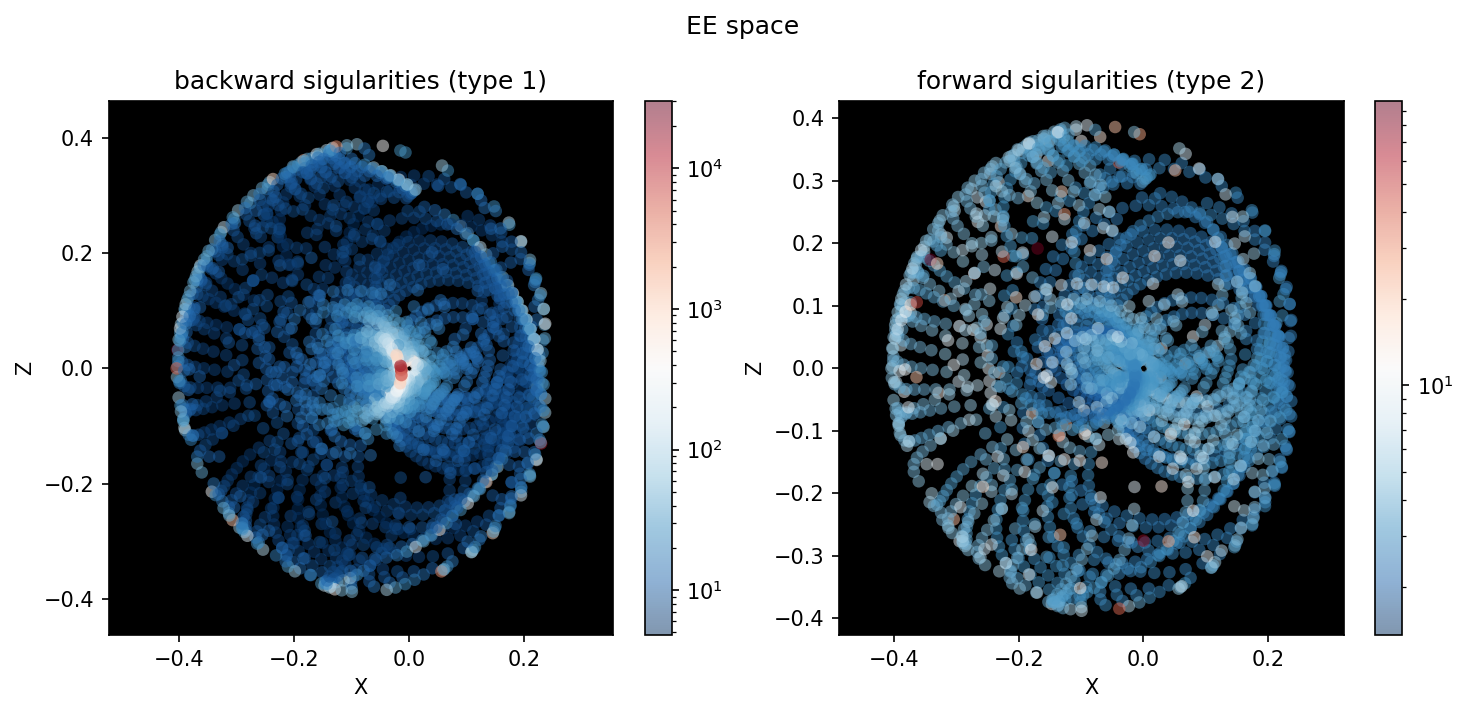

In [27]:
fig = plt.figure(figsize=(10, 4.8), dpi=150) #6.4 4.8
ax = fig.add_subplot(1, 2, 1)
ax.set_facecolor((0., 0., 0.))
# plt.scatter(workspace_xyz[:, 0],  workspace_xyz[:, 2], c=sing_prox, cmap='Spectral_r', norm='log', linewidth=0, alpha=0.3)
# plt.scatter(workspace_xyz[:, 0],  workspace_xyz[:, 2], c=sing_prox, cmap='coolwarm', norm='log', linewidth=0, alpha=0.3)
plt.scatter(workspace_xyz[:, 0],  workspace_xyz[:, 2], c=sing_prox, cmap='RdBu_r', norm='log', linewidth=0,  alpha=0.5)
plt.suptitle("EE space")
plt.title("backward sigularities (type 1)")
plt.xlabel("X")
plt.ylabel("Z")
plt.axis('equal')
plt.colorbar()
# vscale = 1/15
# plt.quiver(workspace_xyz[:, 0], workspace_xyz[:, 2], 
#            rsvecs_ee[:, 0]*vscale, rsvecs_ee[:, 1]*vscale, 
#            color=['w'], angles='xy', scale_units='xy', scale=1)
plt.tight_layout()

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_facecolor((0., 0., 0.))
plt.scatter(workspace_xyz[:, 0],  workspace_xyz[:, 2], c=sing_prox2, cmap='RdBu_r', norm='log', linewidth=0,  alpha=0.5)
plt.title("forward sigularities (type 2)")
plt.xlabel("X")
plt.ylabel("Z")
plt.axis('equal')
plt.tight_layout()
plt.colorbar()
plt.tight_layout()

plt.show()

In [18]:
def plot_pixels(fig, ax, data_x, data_y, colors, x_mindatastep, y_mindatastep, limsx=None, limsy=None):
    ax.set_facecolor((0., 0., 0.))
    fig.canvas.draw()

    st = x_mindatastep
    is_x = True
    if y_mindatastep < x_mindatastep:
        st = y_mindatastep
        is_x = False

    # plt.scatter(q_act[:, 0]/np.pi*180, q_act[:, 1]/np.pi*180, c=sing_prox, cmap='Spectral_r', norm='log', linewidth=0, s=18)
    # plt.scatter(q_act[:, 0]/np.pi*180, q_act[:, 1]/np.pi*180, c=sing_prox, cmap='BrBG', norm='log', linewidth=0, s=18) #'coolwarm'
    scat = plt.scatter(data_x, data_y, c=colors, cmap='RdBu_r', norm='log', linewidth=0, marker='s') # marker='s' s=18
    # plt.scatter(q_act[:, 0]/np.pi*180, q_act[:, 1]/np.pi*180, c=sing_prox, cmap='jet', norm='log', linewidth=0, s=18)
    
    # plt.axis('equal')
    if limsx is not None:
        plt.xlim(limsx)
    if limsy is not None:
        plt.ylim(limsy)
    plt.tight_layout()
    plt.colorbar()
    ax.set_box_aspect(1)
    xl=ax.get_xlim()
    yl=ax.get_ylim()
    w = abs(xl[0]-xl[1]) if is_x else abs(yl[0]-yl[1]) 
    msize = ((ax.get_window_extent().width * 72./fig.dpi / w*st) ** 2)
    scat.set_sizes([msize])

def calc_min_step(arr1D, threshold=0):
    d = np.diff(np.sort(arr1D))
    return d[d>threshold].min()

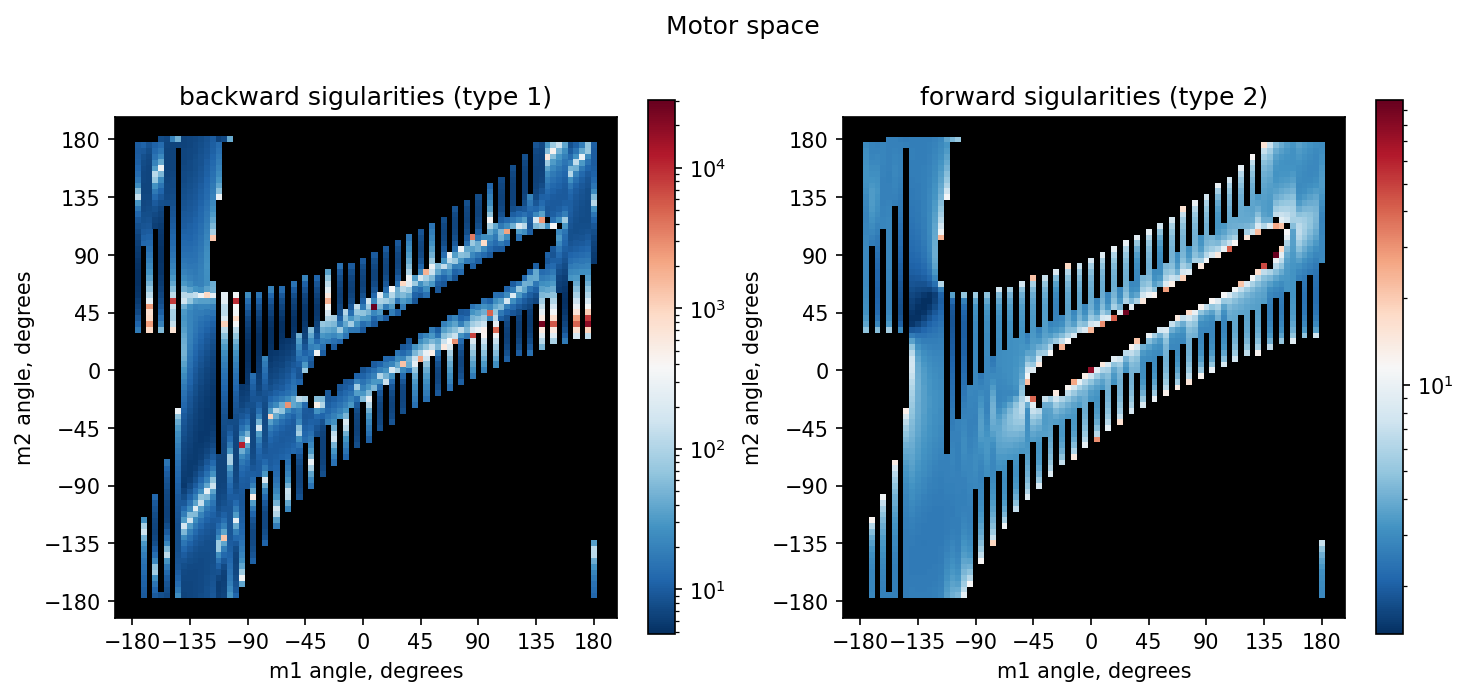

In [28]:
stx = calc_min_step(q_act[:,0])/np.pi*180
sty = calc_min_step(q_act[:,1])/np.pi*180
# svds.append()
fig = plt.figure(figsize=(10, 4.8), dpi=150)
plt.suptitle("Motor space")
ax = fig.add_subplot(1, 2, 1)
plt.title("backward sigularities (type 1)")
plt.xlabel("m1 angle, degrees")
plt.ylabel("m2 angle, degrees")
plot_pixels(fig, ax, q_act[:, 0]/np.pi*180, q_act[:, 1]/np.pi*180, sing_prox, stx, sty)

# vscale = 10
# plt.quiver(q_act[:, 0]/np.pi*180, q_act[:, 1]/np.pi*180, 
#            rsvecs_q[:, 0]*vscale, rsvecs_q[:, 1]*vscale, 
#            color=['g'], angles='xy', scale_units='xy', scale=1)
plt.xticks(np.arange(-180, 181, step=45))
plt.yticks(np.arange(-180, 181, step=45))

ax2 = fig.add_subplot(1, 2, 2)
plt.title("forward sigularities (type 2)")
plt.xlabel("m1 angle, degrees")
plt.ylabel("m2 angle, degrees")
plot_pixels(fig, ax2, q_act[:, 0]/np.pi*180, q_act[:, 1]/np.pi*180, sing_prox2, stx, sty)
plt.xticks(np.arange(-180, 181, step=45))
plt.yticks(np.arange(-180, 181, step=45))

plt.show()

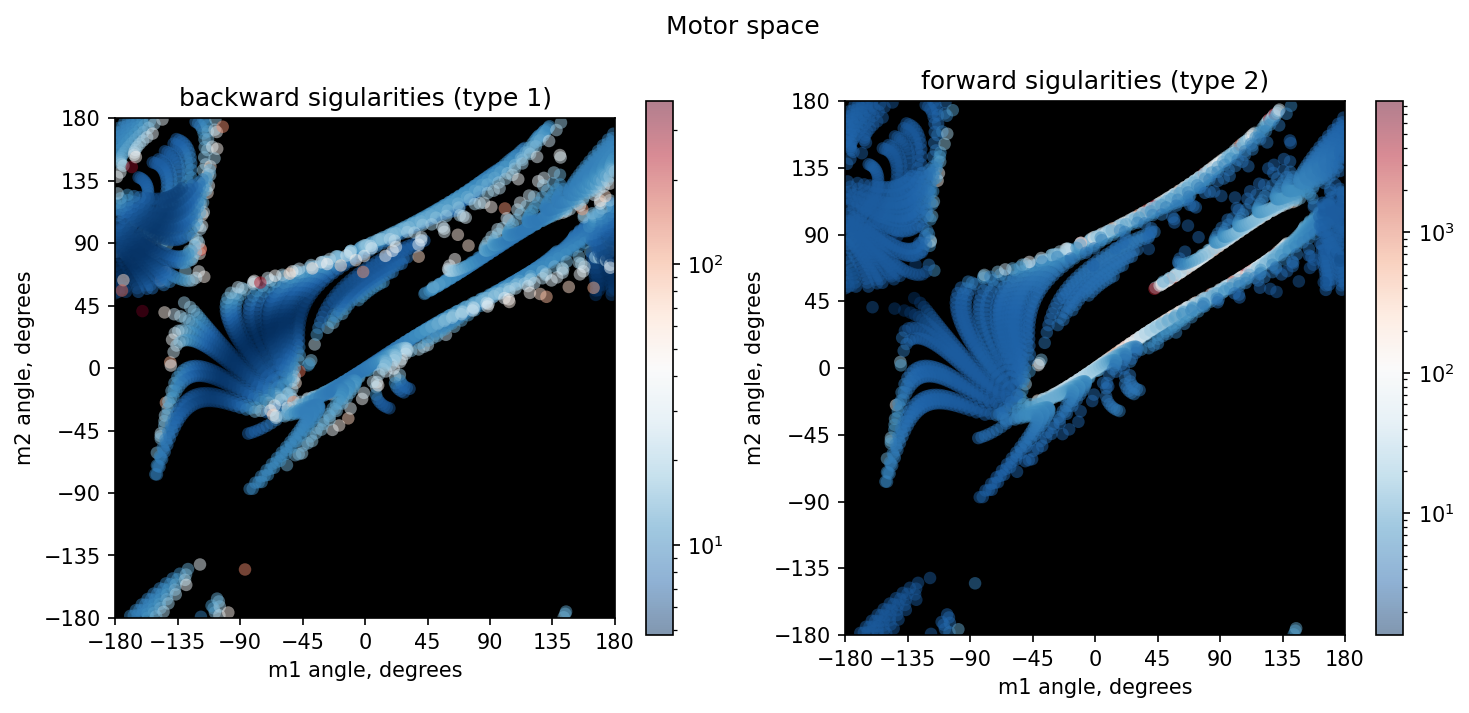

In [38]:
fig = plt.figure(figsize=(10, 4.8), dpi=150) #6.4 4.8
ax = fig.add_subplot(1, 2, 1)
ax.set_facecolor((0., 0., 0.))
plt.scatter(motorspace_q[:, 0]/np.pi*180,  motorspace_q[:, 1]/np.pi*180, c=sing_proxik, cmap='RdBu_r', norm='log', linewidth=0,  alpha=0.5)
plt.suptitle("Motor space")
plt.title("backward sigularities (type 1)")
plt.xlabel("m1 angle, degrees")
plt.ylabel("m2 angle, degrees")

plt.xticks(np.arange(-180, 181, step=45))
plt.yticks(np.arange(-180, 181, step=45))
plt.xlim([-180, 180])
plt.ylim([-180, 180])
# plt.axis('equal')
plt.colorbar()
ax.set_box_aspect(1)
# vscale = 6
# plt.quiver(motorspace_q[:, 0]/np.pi*180, motorspace_q[:, 1]/np.pi*180, 
#            rsvecsik_q[:, 0]*vscale, rsvecsik_q[:, 1]*vscale, 
#            color=['w'], angles='xy', scale_units='xy', scale=1)
plt.tight_layout()

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_facecolor((0., 0., 0.))
plt.title("forward sigularities (type 2)")
plt.xlabel("m1 angle, degrees")
plt.ylabel("m2 angle, degrees")
plt.scatter(motorspace_q[:, 0]/np.pi*180,  motorspace_q[:, 1]/np.pi*180, c=sing_prox2ik, cmap='RdBu_r', norm='log', linewidth=0,  alpha=0.5)
plt.xticks(np.arange(-180, 181, step=45))
plt.yticks(np.arange(-180, 181, step=45))
plt.xlim([-180, 180])
plt.ylim([-180, 180])
plt.colorbar()
ax.set_box_aspect(1)

plt.tight_layout()
plt.show()

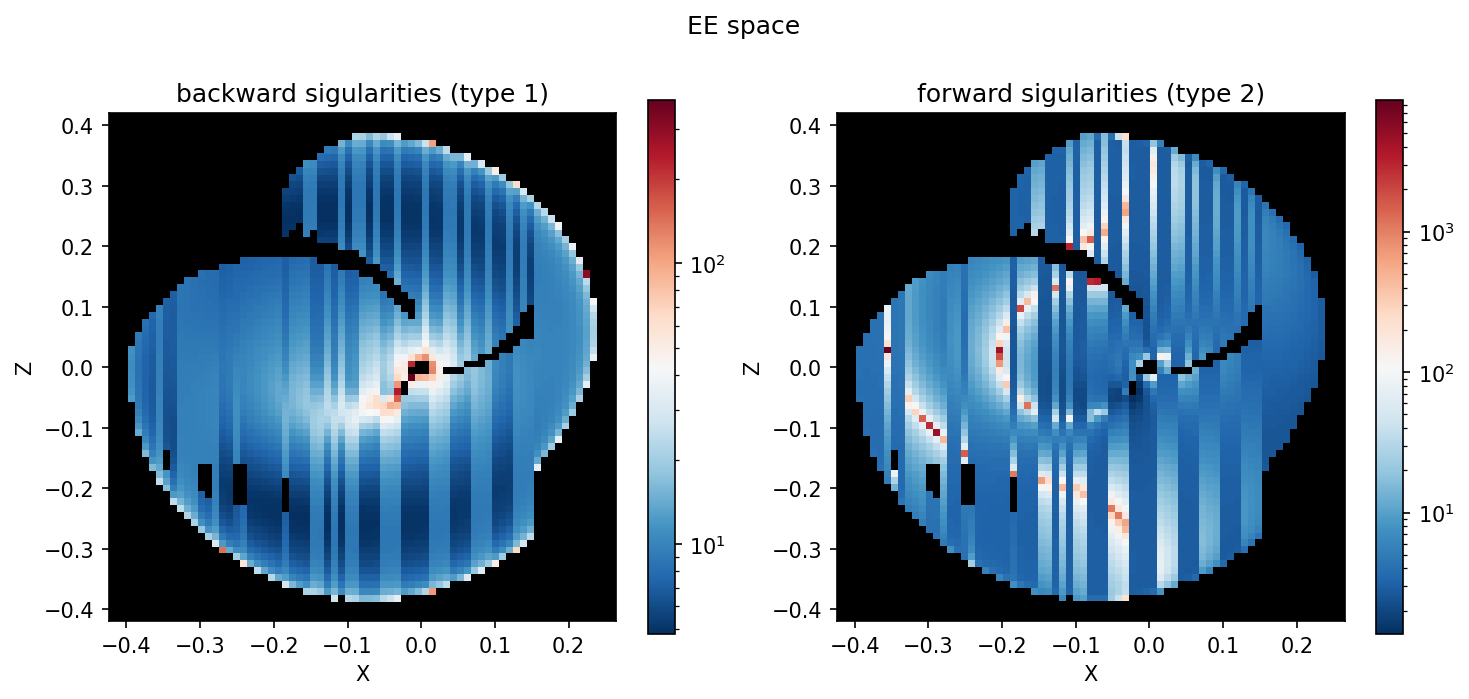

In [39]:
stx = calc_min_step(available_xyz[:,0], 1e-9)
sty = calc_min_step(available_xyz[:,2], 1e-9)

fig = plt.figure(figsize=(10, 4.8), dpi=150)
plt.suptitle("EE space")
ax = fig.add_subplot(1, 2, 1)
plt.title("backward sigularities (type 1)")
plt.xlabel("X")
plt.ylabel("Z")
plot_pixels(fig, ax, available_xyz[:,0], available_xyz[:,2], sing_proxik, stx, sty)

# vscale = 1/20#10
# plt.quiver(available_xyz[:,0], available_xyz[:,2], 
#            rsvecsik_ee[:, 0]*vscale, rsvecsik_ee[:, 1]*vscale, 
#            color=['k'], angles='xy', scale_units='xy', scale=1)

ax2 = fig.add_subplot(1, 2, 2)
plt.title("forward sigularities (type 2)")
plt.xlabel("X")
plt.ylabel("Z")
plot_pixels(fig, ax2, available_xyz[:,0], available_xyz[:,2], sing_prox2ik, stx, sty)

plt.show()

In [40]:
def line_ellipse(a, b, angle=0, div=100):
    t = np.linspace(0, 2*np.pi, div)
    Ell = np.array([a*np.cos(t) , b*np.sin(t)])  
    rot = np.array([[np.cos(angle) , -np.sin(angle)],
                    [np.sin(angle) , np.cos(angle)]])
    Ell_rot = np.zeros((2,Ell.shape[1]))
    for i in range(Ell.shape[1]):
        Ell_rot[:,i] = np.dot(rot,Ell[:,i])
    return Ell_rot

[[ 0.031 -0.166]
 [ 0.029 -0.036]]


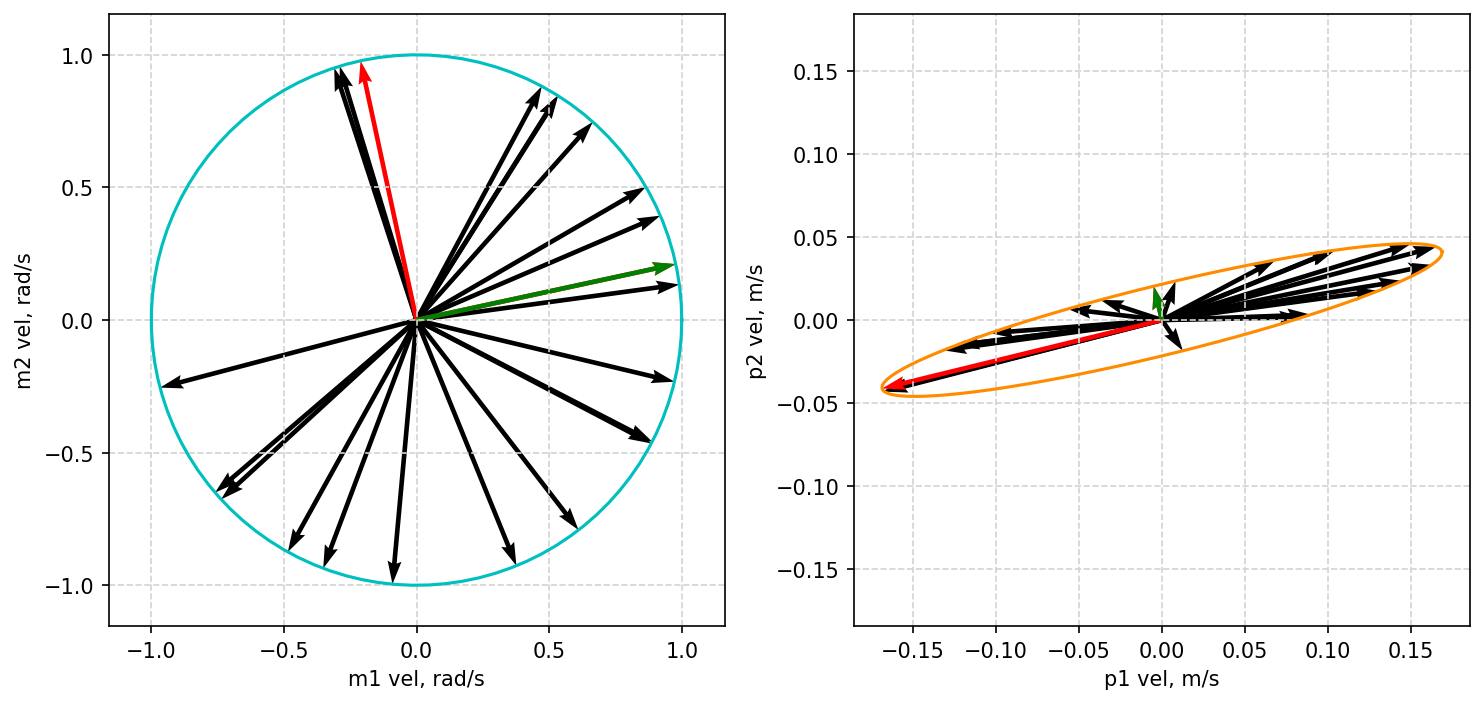

In [41]:
# СДЕЛАТЬ НОРМ МЕХАНИЗМ 5 БАР КАК У ДИСНЕЯ ИЛИ В КНИЖКЕ

ind = 120
Jcl = jacs[ind]
print(Jcl)
U, S, Vh = svds[ind]

angs = np.random.uniform(-np.pi, np.pi, 20)

vecs = np.empty((len(angs), 2))
for i, a in enumerate(angs):
    v = np.asarray([np.cos(a), np.sin(a)])
    vecs[i,:] = v  
    
q_ell = line_ellipse(1,1)  

fig = plt.figure(figsize=(10, 4.8), dpi=150)
ax = fig.add_subplot(1, 2, 1)
plt.plot(q_ell[0,:], q_ell[1,:],'c')
vscale = 1
plt.quiver(np.zeros(len(angs)), np.zeros(len(angs)), vecs[:, 0]*vscale, vecs[:, 1]*vscale, 
           color=['k'], angles='xy', scale_units='xy', scale=1)
plt.quiver(np.zeros(2), np.zeros(2), Vh.T[0, :]*vscale, Vh.T[1, :]*vscale, 
           color=['r'], angles='xy', scale_units='xy', scale=1)
plt.quiver(np.zeros(1), np.zeros(1), rsvecs_q[ind, 0]*vscale, rsvecs_q[ind, 1]*vscale, 
           color=['g'], angles='xy', scale_units='xy', scale=1)
# plt.suptitle("Motor space")
# plt.title("backward sigularities (type 1)")
plt.grid(color='lightgray',linestyle='--')
plt.xlabel("m1 vel, rad/s")
plt.ylabel("m2 vel, rad/s")
plt.axis('equal')
plt.tight_layout()

Us = U*S
# Us = np.empty((2,2))
# Us[:,0] = Jcl@Vh.T[:,0] 
# Us[:,1] = Jcl@Vh.T[:,1]
# Us[:,0] = S[0]*Vh[0,:] # aligned with qvecs
# Us[:,1] = S[1]*Vh[1,:]

vecs2 = np.empty((len(angs), 2))
for i, qa in enumerate(vecs):
    vecs2[i] = Jcl @ qa

ee_ell = line_ellipse(S[0], S[1], np.arctan2(U[1,1],U[0,1])-np.pi/2)

ax = fig.add_subplot(1, 2, 2)
plt.plot(ee_ell[0,:], ee_ell[1,:],'darkorange')
vscale = 1
plt.quiver(np.zeros(len(angs)), np.zeros(len(angs)), vecs2[:, 0]*vscale, vecs2[:, 1]*vscale, 
           color=['k'], angles='xy', scale_units='xy', scale=1)
plt.quiver(np.zeros(2), np.zeros(2), Us[0, :]*vscale, Us[1, :]*vscale, 
           color=['r'], angles='xy', scale_units='xy', scale=1)
plt.quiver(np.zeros(1), np.zeros(1), (Jcl@rsvecs_q[ind, :])[0]*vscale, (Jcl@rsvecs_q[ind, :])[1]*vscale, 
           color=['g'], angles='xy', scale_units='xy', scale=1)
# plt.suptitle("Motor space")
# plt.title("backward sigularities (type 1)")
plt.grid(color='lightgray',linestyle='--')
plt.xlabel("p1 vel, m/s")
plt.ylabel("p2 vel, m/s")
plt.axis('equal')
plt.tight_layout()

plt.show()

ValueError: Argument U has a size 5 which does not match 2, the number of arrow positions

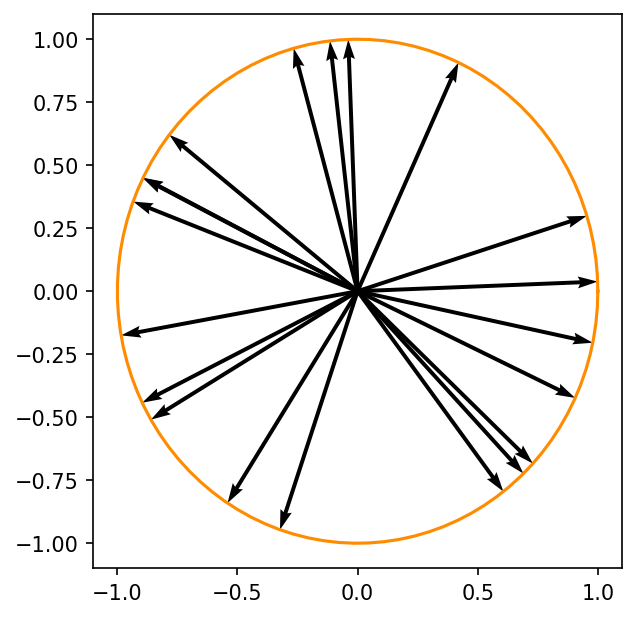

In [42]:
Jclinv = np.linalg.pinv(Jcl)
# TODO take pinv from orig jac, not cut
U, S, Vh = svds_inv[ind]

angs = np.random.uniform(-np.pi, np.pi, 20)

vecs = np.empty((len(angs), 2))
for i, a in enumerate(angs):
    v = np.asarray([np.cos(a), np.sin(a)])
    vecs[i,:] = v  
    
ee_ell = line_ellipse(1,1)  

fig = plt.figure(figsize=(10, 4.8), dpi=150)
ax = fig.add_subplot(1, 2, 1)
plt.plot(ee_ell[0,:], ee_ell[1,:],'darkorange')
vscale = 1
plt.quiver(np.zeros(len(angs)), np.zeros(len(angs)), vecs[:, 0]*vscale, vecs[:, 1]*vscale, 
           color=['k'], angles='xy', scale_units='xy', scale=1)
plt.quiver(np.zeros(2), np.zeros(2), Vh.T[0, :]*vscale, Vh.T[1, :]*vscale, 
           color=['r'], angles='xy', scale_units='xy', scale=1)
# plt.suptitle("Motor space")
# plt.title("backward sigularities (type 1)")
plt.grid(color='lightgray',linestyle='--')
plt.xlabel("p1 vel, m/s")
plt.ylabel("p2 vel, m/s")
plt.axis('equal')
plt.tight_layout()

Us = U*S
# Us = np.empty((2,2))
# Us[:,0] = Jclinv@Vh.T[:,0] 
# Us[:,1] = Jclinv@Vh.T[:,1]
# Us[:,0] = S[0]*Vh[0,:] # aligned with qvecs
# Us[:,1] = S[1]*Vh[1,:]

vecs2 = np.empty((len(angs), 2))
for i, qa in enumerate(vecs):
    vecs2[i] = Jcl @ qa

q_ell = line_ellipse(S[0], S[1], np.arctan2(U[1,1],U[0,1])-np.pi/2)

ax = fig.add_subplot(1, 2, 2)
plt.plot(q_ell[0,:], q_ell[1,:],'c')
vscale = 1
plt.quiver(np.zeros(len(angs)), np.zeros(len(angs)), vecs2[:, 0]*vscale, vecs2[:, 1]*vscale, 
           color=['k'], angles='xy', scale_units='xy', scale=1)
plt.quiver(np.zeros(2), np.zeros(2), Us[0, :]*vscale, Us[1, :]*vscale, 
           color=['r'], angles='xy', scale_units='xy', scale=1)
# plt.suptitle("Motor space")
# plt.title("backward sigularities (type 1)")
plt.grid(color='lightgray',linestyle='--')
plt.xlabel("m1 vel, rad/s")
plt.ylabel("m2 vel, rad/s")
plt.axis('equal')
plt.tight_layout()

plt.show()